In [31]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt



class Cov:
    def __init__(self, h=0.2):
        self.h = h 

    def gamma(self, s):
        return (np.power(np.abs(s - 1), 2 * self.h) + np.power(np.abs(s + 1), 2 * self.h) - 2 * np.power(np.abs(s), 2 * self.h))/2

class Structure:
    def __init__(self, sample_size=100):
        self.sample_size = sample_size
    
    def __str__(self):
        return f'the sample size {self.sample_size}, h paramater {self.h}'
    
    def matrix(self, cov_instance=Cov()):
        """return the covariance structure matrix here g(h, h) = 1"""
        n = self.sample_size
        cov = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                diff = i - j
                cov[i][j] = cov_instance.gamma(diff)
        return cov

class GaussianProcess:
    """
    attributes
    ----------
    cov_structure: stationnary covariance of multifractional gaussian process
    n: number of realizations of Y we want to generate
    methods
    -------
    get_params: get circular matrix and integer parameter m 
    spectrum: eigenvalues of circular matrix
    simulate_gaussian_process: main function
    slice_circular: generate circular matrix
    embedding_length: m parameter 
    check_symmetric: return True if arg is a symetric matrix
    """
    def __init__(self, cov_structure, cov_instance=Cov()):
        self.__cov_structure = cov_structure
        self.n = cov_structure.shape[0]
        self.cov_instance = cov_instance

    def __get_params(self, **kwargs):
        if kwargs:
            m = kwargs['embedding_value'] * 2
        else:
            m = self.__embedding_length(n=self.n)

        # get circular matrix pattern
        gamma0 = self.cov_structure[0,:] 
        theta0 = np.array([self.cov_instance.gamma(k) for k in range(m // 2 + 1)] + [self.cov_instance.gamma(k) for k in range(m // 2 + 1 , m)])
        return self.__slice_circular(theta0), m


    def __spectrum(self):
        """compute eigenvalues and eigenvectors of linear operator"""
        circular_matrix, m = self.__get_params()
        eigenvalues, eigenvectors = np.linalg.eig(circular_matrix)

        while not np.all(eigenvalues >= 0):
            print('not sdp')
            circular_matrix, m = self.__get_params(embedding_value=m)
            eigenvalues, eigenvectors = np.linalg.eig(circular_matrix)

        return eigenvalues, eigenvectors
    
    def simulate_gaussian_process(self):
        """simulate the gaussian process"""
        eigenvalues, Q = self.__spectrum()
        print('get_eigenvalues')
        gamma = np.diag(np.sqrt(eigenvalues))
        print('get_gamma')
        random_normal = np.random.normal(0, 1, gamma.shape[0]).reshape(-1, 1)
        a = gamma.dot(Q.T).dot(random_normal).flatten()
        print('get_multiply')
        return np.real(np.fft.fft(a)[:self.n]) 

    def generateFBM(self, delta, gp):
        fbm = []
        coeff = np.power(delta, self.cov_instance.h)
        for i in range(self.n):
            fbm.append(coeff * gp[:i+1].sum())

        return np.array(fbm)
         


    @staticmethod
    def __slice_circular(vector):
        """ generate circular matrix from a list pattern as first row"""
        ntimes = len(vector) - 1
        matrix = vector
        permute = vector.tolist()
        for i in range(ntimes):
            permute = [permute[-1]] + permute[:-1]
            matrix = np.vstack([matrix, permute])
        return matrix

    @staticmethod
    def __embedding_length(n):
      """for circular embedding matrix calculation
      return_back arg enable increse the power of g in 
      computed eigenvalues are negative
      """
      return np.power(2, int(1 + np.log(n - 1) / np.log(2)) + 1)

    @staticmethod 
    def __check_symmetric(a, tol=1e-8):
        """
        return if a given matrix is symetric or not with given confidence
        intervall
        """
        return np.all(np.abs(a-a.T) < tol)

    @property 
    def cov_structure(self):
      return self.__cov_structure 

    @cov_structure.setter
    def cov_structure(self, new_value):
        if isinstance(new_value, np.ndarray):
            row, col = new_value.shape
            is_symetric = self.__check_symmetric(new_value)
            is_square = row == col
            if is_square and is_symetric:
                self.__cov_structure = new_value
            else:
                raise('Try to give well define Matrix -- SPD')
        else:
            raise('Except ndarray object')



In [32]:
cis = Cov()
matrix = Structure().matrix(cis)
matrix

array([[ 1.00000000e+00, -3.40246045e-01, -4.35851238e-02, ...,
        -7.94991478e-05, -7.82051227e-05, -7.69449810e-05],
       [-3.40246045e-01,  1.00000000e+00, -3.40246045e-01, ...,
        -8.08283308e-05, -7.94991478e-05, -7.82051227e-05],
       [-4.35851238e-02, -3.40246045e-01,  1.00000000e+00, ...,
        -8.21940084e-05, -8.08283308e-05, -7.94991478e-05],
       ...,
       [-7.94991478e-05, -8.08283308e-05, -8.21940084e-05, ...,
         1.00000000e+00, -3.40246045e-01, -4.35851238e-02],
       [-7.82051227e-05, -7.94991478e-05, -8.08283308e-05, ...,
        -3.40246045e-01,  1.00000000e+00, -3.40246045e-01],
       [-7.69449810e-05, -7.82051227e-05, -7.94991478e-05, ...,
        -4.35851238e-02, -3.40246045e-01,  1.00000000e+00]])

In [33]:
gp = GaussianProcess(matrix, cis)

In [34]:
x = gp.simulate_gaussian_process()

get_eigenvalues
get_gamma
get_multiply


In [35]:

brm = gp.generateFBM(delta=.01, gp=x)

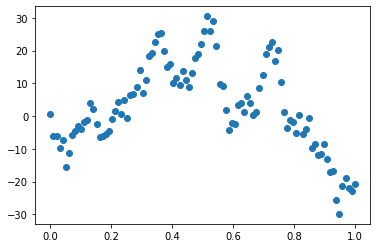

In [38]:
plt.scatter(np.linspace(0, 1, 100), brm)





In [101]:
_cov(3, 0.1)

array([[ 2.        , -0.85130165, -0.05166577],
       [-0.85130165,  2.        , -0.85130165],
       [-0.05166577, -0.85130165,  2.        ]])

In [1]:
m = 4
m//2 + 1

3